## Masked Autoencoders: Visualization Demo

This is a visualization demo using pre-trained MAE models.

### Prepare


In [11]:
import warnings
warnings.filterwarnings("ignore")

import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

# check whether run in Colab
# !pip3 install timm==0.4.5  # 0.3.2 does not work in Colab
# !git clone https://github.com/facebookresearch/mae.git
sys.path.append('./mae')
import models_mae

### Define utils

In [2]:
# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
#     assert image.shape[2] == 3
    plt.imshow(image)
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(model)
    return model

def run_one_image(img, model, mask_ratio=0.75):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=mask_ratio)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()

    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

### Load an image

In [3]:
""" Load H&E patched images """
import pickle

with open('imgs.pkl', 'rb') as f:
    imgs = pickle.load(f)

In [4]:
print(f"There are {len(imgs)} samples.\n")

print(f"There are {imgs[0].shape[0]} patched images in sample A1. ")


There are 7 samples.

There are 346 patched images in sample A1. 


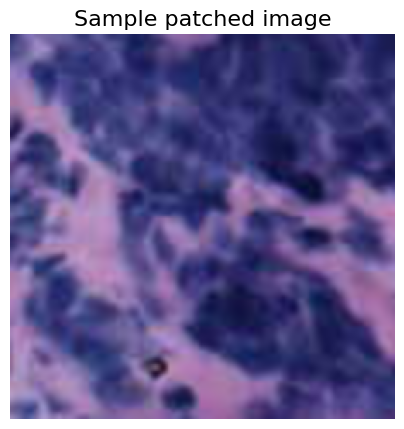

In [5]:
import torchvision
transforms = torch.nn.Sequential(
    torchvision.transforms.Resize((224, 224)),
)

# Sample a patched image
img1 = imgs[1][8]
img1 = transforms(img1).permute(1,2,0)/255.

plt.rcParams['figure.figsize'] = [5, 5]
show_image(img1, "Sample patched image")
# plt.imshow(img1)

### Load a pre-trained MAE model

In [6]:
# This is an MAE model trained with pixels as targets for visualization (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large.pth

chkpt_dir = 'mae_visualize_vit_large.pth'
model_mae = prepare_model(chkpt_dir, 'mae_vit_large_patch16')
print('Model loaded.')


File ‘mae_visualize_vit_large.pth’ already there; not retrieving.

MaskedAutoencoderViT(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
  )
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elemen

### Run MAE on the image

MAE with pixel reconstruction(mask_ratio:0.25):


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


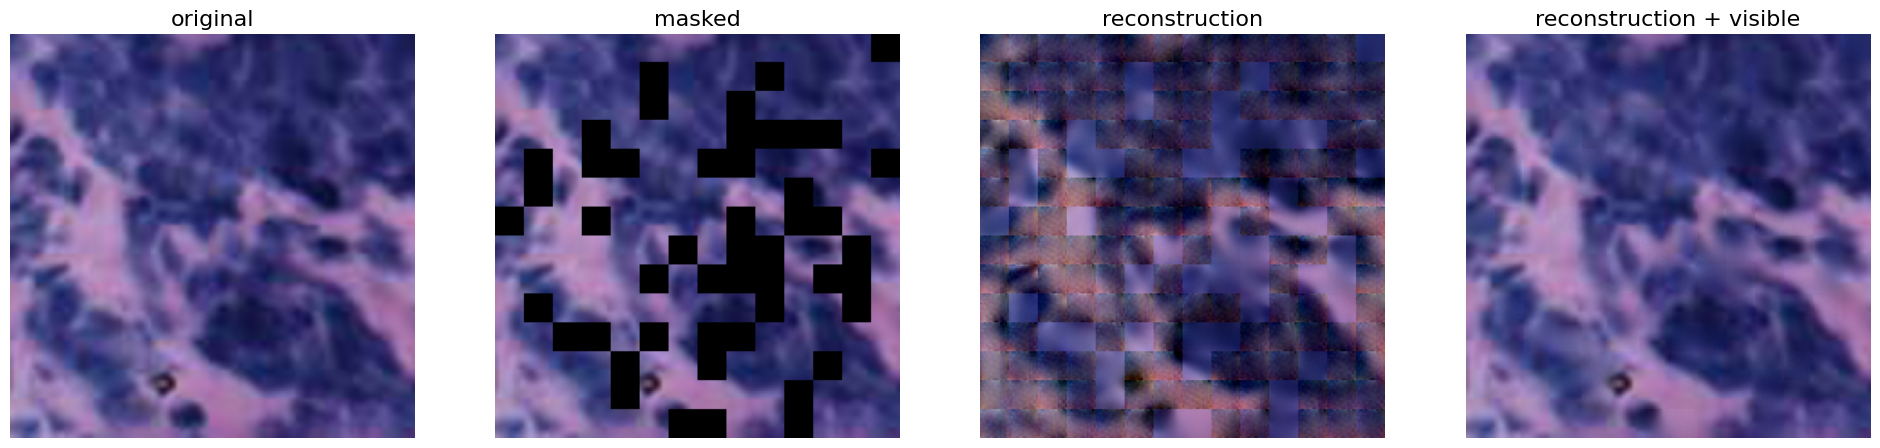

MAE with pixel reconstruction(mask_ratio:0.5):


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


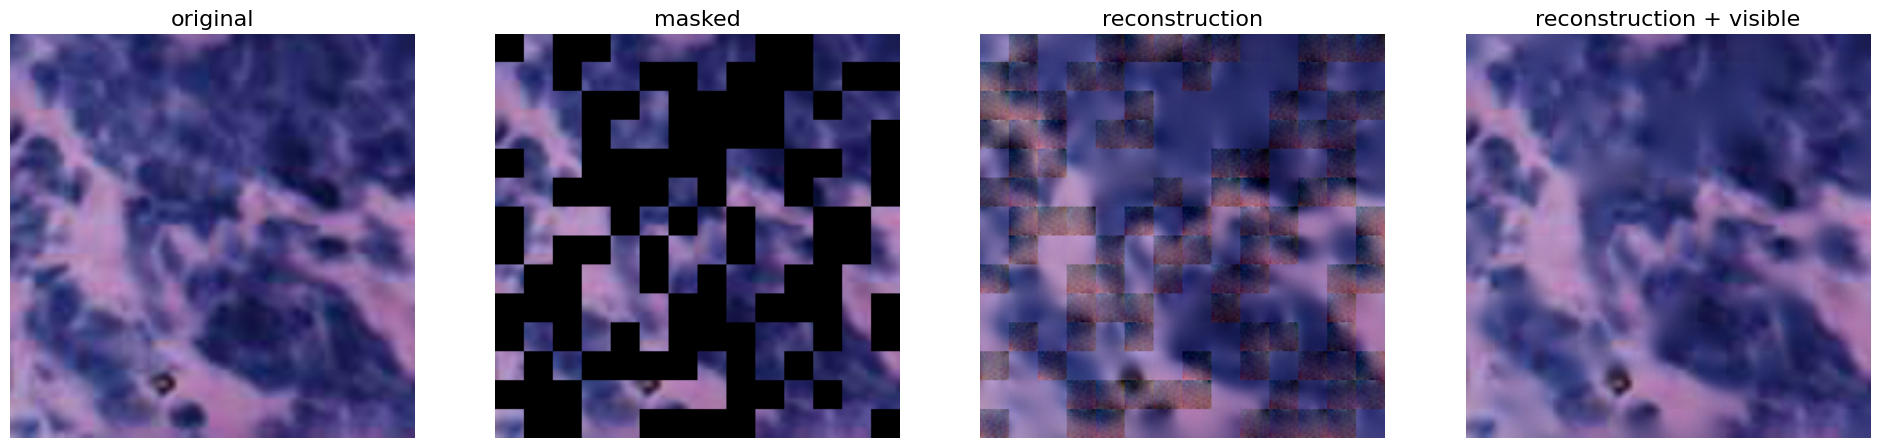

MAE with pixel reconstruction(mask_ratio:0.75):


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


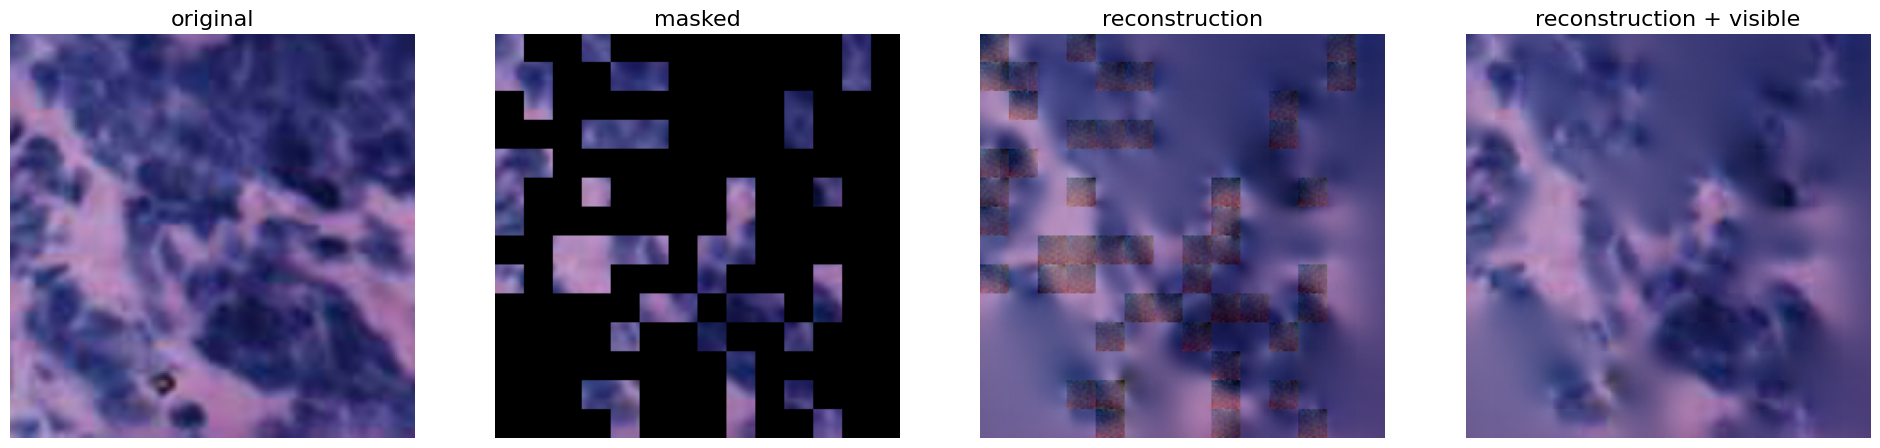

In [7]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)

mask_ratio = 0.25
print(f'MAE with pixel reconstruction(mask_ratio:{mask_ratio}):')
run_one_image(img1, model_mae, mask_ratio)

mask_ratio = 0.50
print(f'MAE with pixel reconstruction(mask_ratio:{mask_ratio}):')
run_one_image(img1, model_mae, mask_ratio)

mask_ratio = 0.75
print(f'MAE with pixel reconstruction(mask_ratio:{mask_ratio}):')
run_one_image(img1, model_mae, mask_ratio)


### Load another pre-trained MAE model

In [8]:
# This is an MAE model trained with an extra GAN loss for more realistic generation (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large_ganloss.pth

chkpt_dir = 'mae_visualize_vit_large_ganloss.pth'
model_mae_gan = prepare_model('mae_visualize_vit_large_ganloss.pth', 'mae_vit_large_patch16')
print('Model loaded.')


File ‘mae_visualize_vit_large_ganloss.pth’ already there; not retrieving.

MaskedAutoencoderViT(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
  )
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((1024,), eps=1e-06

### Run MAE on the image

MAE with pixel reconstruction(mask_ratio:0.25):


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


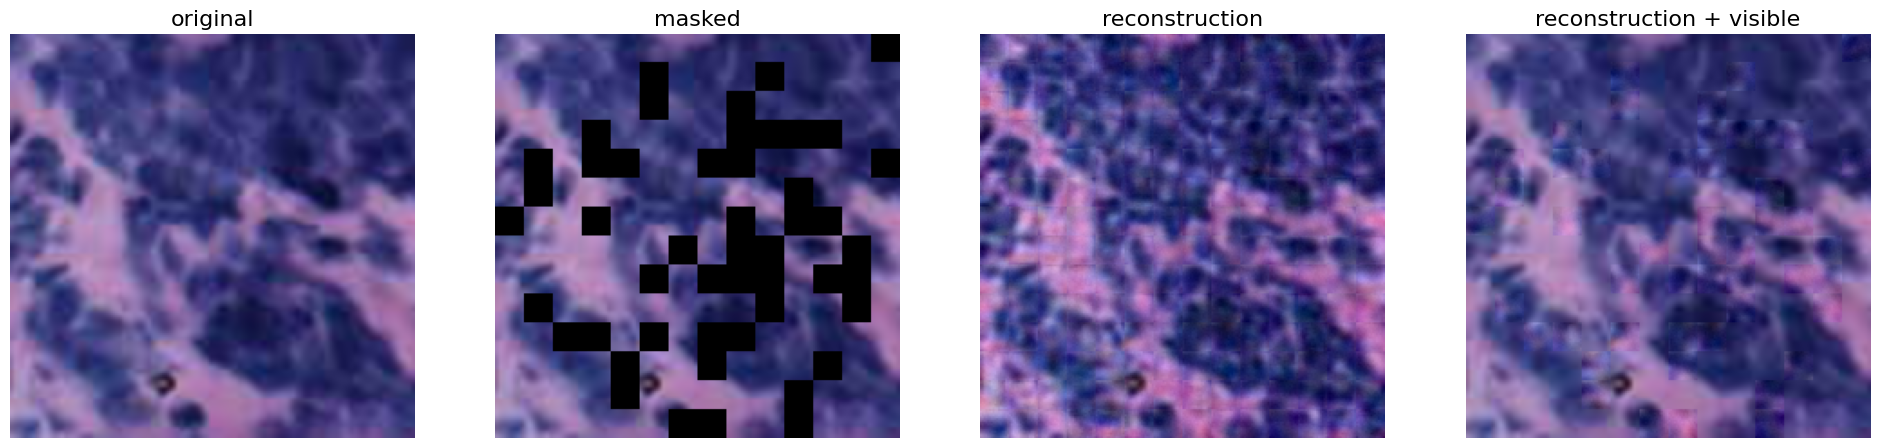

MAE with pixel reconstruction(mask_ratio:0.5):


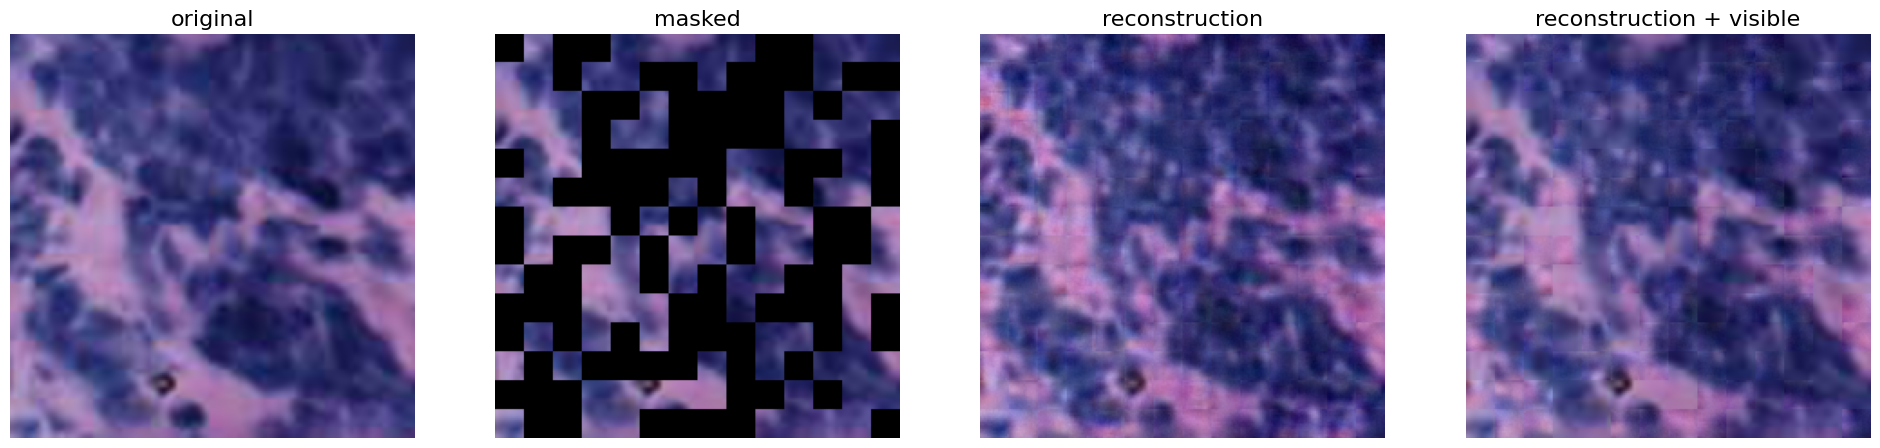

MAE with pixel reconstruction(mask_ratio:0.75):


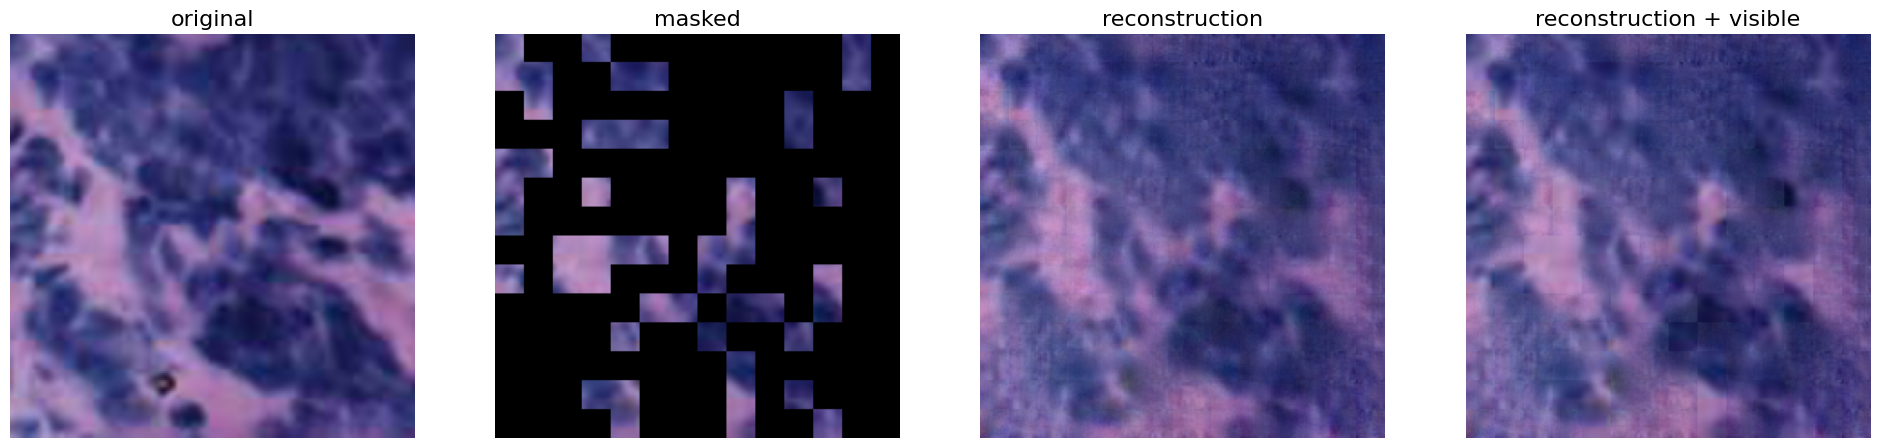

In [9]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)

mask_ratio = 0.25
print(f'MAE with pixel reconstruction(mask_ratio:{mask_ratio}):')
run_one_image(img1, model_mae_gan, mask_ratio)

mask_ratio = 0.50
print(f'MAE with pixel reconstruction(mask_ratio:{mask_ratio}):')
run_one_image(img1, model_mae_gan, mask_ratio)

mask_ratio = 0.75
print(f'MAE with pixel reconstruction(mask_ratio:{mask_ratio}):')
run_one_image(img1, model_mae_gan, mask_ratio)